In [23]:
# 定义目标函数 此函数在0.78附近取得最小值
def f(x):
    return x**4 - 14 * x**3 + 60 * x**2 - 70 * x

## 等比例压缩法

每次评估两个点，以固定的比例一步步压缩区间，直到满足精度需求

$$
\frac{b_1-a_0}{b_0-a_0} = \frac{b_0-a_1}{b_0-a_0} = \rho
$$

经过n次划分之后，最终区间长度与初始长度比值为：

$$
(1-\rho)^n
$$

**压缩比需要大于0.5，否则无法找到极值**

In [24]:
# 定义等比例压缩法
def na(a_0, b_0, rate):
    return b_0 - rate * (b_0 - a_0)

def nb(a_0, b_0, rate):
    return a_0 + rate * (b_0 - a_0)

In [48]:
#%%timeit 
# 100000 loops, best of 5: 3.15 µs per loop
# 1.每一次的压缩比为超参数
rho = 0.765
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3

while (b - a) > acc:
  a_1 = na(a, b, rho)
  b_1 = nb(a, b, rho)
  print(a,a_1,b_1,b)
  if f(a_1) > f(b_1):
      a = a_1
  else:
      b = b_1
  print("此时a:{} b:{},区间长度{}".format(a, b, b - a))

0 0.47 1.53 2
此时a:0 b:1.53,区间长度1.53
0 0.35955000000000004 1.17045 1.53
此时a:0.35955000000000004 b:1.53,区间长度1.17045
0.35955000000000004 0.63460575 1.25494425 1.53
此时a:0.35955000000000004 b:1.25494425,区间长度0.8953942500000001
0.35955000000000004 0.56996764875 1.04452660125 1.25494425
此时a:0.35955000000000004 b:1.04452660125,区间长度0.68497660125
0.35955000000000004 0.52051950129375 0.8835570999562501 1.04452660125
此时a:0.52051950129375 b:1.04452660125,区间长度0.52400709995625
0.52051950129375 0.6436611697834688 0.9213849327602813 1.04452660125
此时a:0.6436611697834688 b:1.04452660125,区间长度0.4008654314665313
0.6436611697834688 0.7378645461781036 0.9503232248553652 1.04452660125
此时a:0.6436611697834688 b:0.9503232248553652,区间长度0.3066620550718965
0.6436611697834688 0.7157267527253645 0.8782576419134696 0.9503232248553652
此时a:0.6436611697834688 b:0.8782576419134696,区间长度0.2345964721300008


等比例压缩法可以得到正确结果


In [39]:
%%timeit 
# 100000 loops, best of 5: 3.15 µs per loop
rho = 0.5
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3

while (b - a) > acc:
    a_1 = na(a, b, rho)
    b_1 = nb(a, b, rho)
    if f(a_1) > f(b_1):
        a = a_1
    else:
        b = b_1
    # print("此时a:{} b:{},区间长度{}".format(a, b, b - a))

100000 loops, best of 5: 4.86 µs per loop


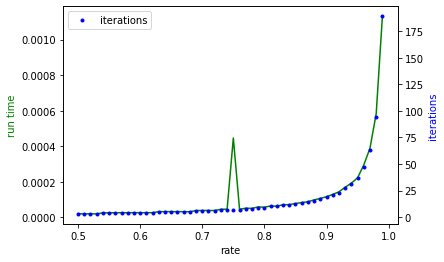

In [45]:
import numpy as np
# 衡量第一种方法超参数与运行时间的关系
rho = np.arange(0.5,1,0.01)
result = [] # 运行时间
iter_num = [] # 循环次数
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3
count = 0

def method1(a, b, acc, rate, funtion):
    global count # 因为timeit不能返回函数的返回值，所以用global把这个变量弄出去
    count = 0
    while (b - a) > acc:
        a_1 = na(a, b, rate)
        b_1 = nb(a, b, rate)
        if funtion(a_1) > funtion(b_1):
            a = a_1
        else:
            b = b_1
        count += 1

for i in rho:
    run_time = %timeit -n100 -o -q method1(a, b, acc, i, f)
    result.append(run_time.best)
    iter_num.append(count)

# 绘图
import matplotlib.pyplot as plt
# 设置次坐标轴
fig, time_axis = plt.subplots()
iter_axis = time_axis.twinx()

time_axis.plot(rho,result,'g-',label='time') # 为什么这个图例不显示呢。。。(摊手)
iter_axis.plot(rho,iter_num,'b.',label='iterations')

time_axis.set_xlabel("rate")
time_axis.set_ylabel("run time",color='g')
iter_axis.set_ylabel("iterations",color='b')
plt.legend()
plt.show()

上图可以发现一个很奇怪的地方。。为什么rate=0.765的时候用时会突然增大呢

## 黄金分割法
找到一个合适的比例$\rho$，使得下一次运算时该点可重复使用
> 在上图中可以观察到，黄金分割比$\rho=\frac{3-\sqrt5}{2}$处并没有明显性能提升，原因是代码中每一次都代入函数求函数值，并没有使用历史结果 
---
下面对代码进行改进

In [49]:
# 函数修改
class function:
  def __init__(self,f):
    self.history = {}
    self.f = f

  def find(self,x): # 返回函数值
    try:
      return self.history[x]
    except KeyError:
      result = self.f(x)
      self.history[x] = result
      return result
  
  def clear(self): # 清空历史
    self.history = {}

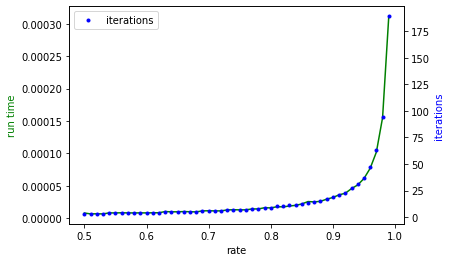

In [50]:
import numpy as np

rho = np.arange(0.5,1,0.01)
result = [] # 运行时间
iter_num = [] # 循环次数
funtion_history = {}
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3
count = 0

# 实例化
fun = function(f)

for i in rho:
    run_time = %timeit -n100 -o -q method1(a, b, acc, i, fun.find)
    result.append(run_time.best)
    iter_num.append(count)
    fun.clear()

# 绘图
import matplotlib.pyplot as plt
# 设置次坐标轴
fig, time_axis = plt.subplots()
iter_axis = time_axis.twinx()

time_axis.plot(rho,result,'g-',label='time') # 为什么这个图例不显示呢。。。(摊手)
iter_axis.plot(rho,iter_num,'b.',label='iterations')

time_axis.set_xlabel("rate")
time_axis.set_ylabel("run time",color='g')
iter_axis.set_ylabel("iterations",color='b')
plt.legend()
plt.show()

可以观察到，在添加历史信息之后，在循环次数不变的情况下，函数运行时间得到了较大提升(观察左侧纵坐标)，同时那个尖峰不见了、、，但是在黄金分割比处仍然没有明显提升。推测原因是函数太过简单，导致无法突出历史查询的优势，下面将尝试**模拟**一个更复杂的函数。
模拟方法如下：
* 如果需要代入函数求解，那么增加0.1秒延时再返回数据
* 如果曾经求解过，那么直接返回

同时减少timeit的循环次数

In [75]:
from time import sleep
# 函数修改
class function:
  def __init__(self,f):
    self.history = {}
    self.f = f

  def find(self,x): # 返回函数值
    try:
      return self.history[x]
    except KeyError:
      result = self.f(x)
      # 增加0.1s延时
      sleep(0.0001)
      self.history[x] = result
      return result
  
  def clear(self): # 清空历史
    self.history = {}

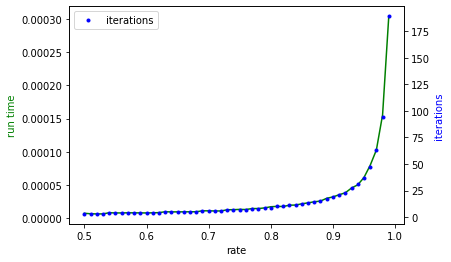

In [76]:
import numpy as np

rho = np.arange(0.5,1,0.01)
result = [] # 运行时间
iter_num = [] # 循环次数
funtion_history = {}
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3
count = 0

# 实例化
fun = function(f)

for i in rho:
    run_time = %timeit -n10 -o -q method1(a, b, acc, i, fun.find)
    result.append(run_time.best)
    iter_num.append(count)
    fun.clear()

# 绘图
import matplotlib.pyplot as plt
# 设置次坐标轴
fig, time_axis = plt.subplots()
iter_axis = time_axis.twinx()

time_axis.plot(rho,result,'g-',label='time') # 为什么这个图例不显示呢。。。(摊手)
iter_axis.plot(rho,iter_num,'b.',label='iterations')

time_axis.set_xlabel("rate")
time_axis.set_ylabel("run time",color='g')
iter_axis.set_ylabel("iterations",color='b')
plt.legend()
plt.show()

*说实话。。尝试了多组数据之后并没有发现什么区别。。。不知道问题出在了哪里呢。。*

## 斐波那契法


允许p动态改变，使得N次迭代之后压缩比最小

同时需要满足每一次迭代只能增加一个点

使用斐波那契法可以获得更优的压缩比，但是黄金分割法更加简单，使用也更多。

在N趋近于无穷的时候，黄金分割法实际上和斐波那契法有相同的压缩比。

斐波那契法需要预先知道总共迭代次数N



In [59]:
# 定义斐波那契数列
fibonacci_array = [0,1,1,2,3,5,8,13,21]
def fibonacci(x):
  return fibonacci_array[x+1]

In [60]:
# 斐波那契法
def method2(a, b, acc, iter_count, epsilon, funtion):
  for i in range(iter_count + 1, 1):
    rate = 1 - fibonacci(i - 1) / fibonacci(i) if fibonacci(i - 1) / fibonacci(i) != 0.5 else fibonacci(
        i - 1) / fibonacci(i) + epsilon
    a_1 = na(a, b, rate)
    b_1 = nb(a, b, rate)
    if funtion(a_1) > funtion(b_1):
        a = a_1
    else:
        b = b_1
    print("此时a:{} b:{},区间长度{}".format(a, b, b - a))


In [61]:
%%timeit
# The slowest run took 17.08 times longer than the fastest. This could mean that an intermediate result is being cached.
# 100000 loops, best of 5: 2.14 µs per loop

import numpy as np

rho = np.arange(0,1,0.01)
result = [] # 运行时间
iter_num = [] # 循环次数
funtion_history = {}
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.3

# 实例化
fun = function(f)
method2(a, b, acc, 4, 0.05, fun.find)

The slowest run took 18.60 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.1 µs per loop


## 二分法
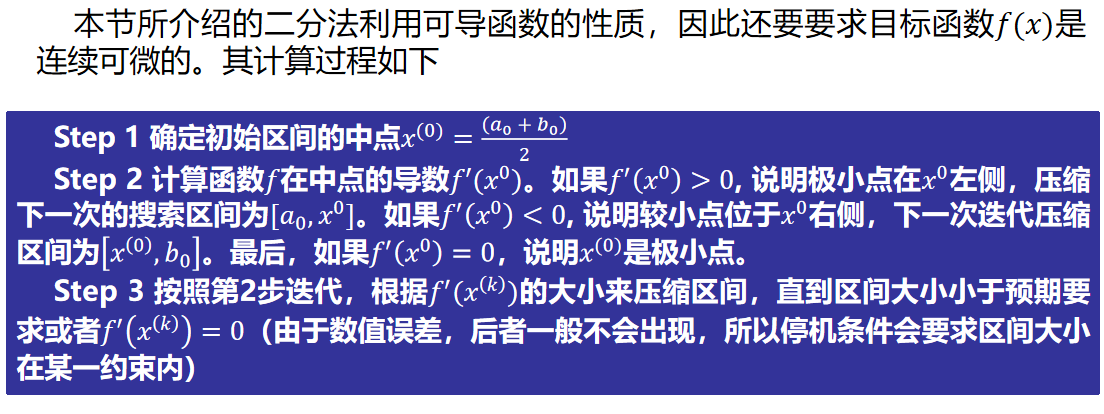

In [66]:
# 二分法 定义变量
import sympy
var_x = sympy.symbols("var_x")  # 符号x，自变量
var_y = var_x**4 - 14 * var_x**3 + 60 * var_x**2 - 70 * var_x

dify = sympy.diff(var_y,var_x) #求导

def middle(x,y):
  return (x+y)/2

def method3(a, b, acc):
  while (b-a) > acc:
    mid = middle(a,b)
    grad = dify.subs('var_x',mid) # 求出中间值的导数
    if grad > 0:
        b = mid
    elif grad < 0:
        a = mid
    else:
      break # 当前即为最值点

In [65]:
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.0003

method3(a, b, acc)

0 1.0
0.5 1.0
0.75 1.0
0.75 0.875
0.75 0.8125
0.75 0.78125
0.765625 0.78125
0.7734375 0.78125
0.77734375 0.78125
0.779296875 0.78125
0.7802734375 0.78125
0.78076171875 0.78125
0.78076171875 0.781005859375


二分法可以得到正确结果

In [67]:
%%timeit
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.0003

method3(a, b, acc)

1000 loops, best of 5: 846 µs per loop


可以看到，二分法的执行时间远远大于其他方法，主要原因是求导耗时过长，如果直接给出导函数进行计算可以缩短执行时间。

In [71]:
def grad_f(x):
  return 4*x**3 - 14*3 * x**2 + 120 * x - 70

def method4(a, b, acc):
  while (b-a) > acc:
    mid = middle(a,b)
    grad = grad_f(mid) # 求出中间值的导数
    if grad > 0:
        b = mid
    elif grad < 0:
        a = mid
    else:
      break # 当前即为最值点

In [72]:
%%timeit
# 定义初始区间范围 (a < b)
a = 0
b = 2
# 定义精度
acc = 0.0003

method4(a, b, acc)

100000 loops, best of 5: 10.2 µs per loop


最终测试结果：

* 黄金分割法结果：100000 loops, best of 5: 4.86 µs per loop

* 斐波那契法结果：100000 loops, best of 5: 2.14 µs per loop

* 二分法(不给出导函数)：1000 loops, best of 5: 846 µs per loop

* 二分法(给出导函数)：100000 loops, best of 5: 10.2 µs per loop